## Pesos de Evidencia - Weight of evidence WoE

Pesos de Evidencia - Weight of Evidence (WoE) por sus siglas en inglés fue desarrollado principalmente por las industrias de crédito y financieras para construir mejores modelos para la predicción de riesgo de incumplimiento de pago en préstamos. Es decir, predecir que tan probable es que el dinero prestado a una persona o institución no sea devuelto. El Peso de Evidencia, es una medida de la "fortaleza" de una técnica de agrupamiento para separar riesgo alto y bajo (riesgo de incumplimiento).

- WoE será 0 si P(positivos) / P(negativos) = 1, es decir, si el resultado es aleatorio para ese grupo.
- SiP(positivos) > P(negativos)  el índice de probabilidad será < 1 y,
- WoE  será < 0 si,  P(positivos) > P(negativos) .

WoE es adecuado para Regresiones Logísticas porque la transformación Logit es simplemente el logaritmo de la probabilidad, es decir, ln( P(positivos)/ P(negativos)). Por lo tanto, usando variables codificadas con WoE en los regresores logísticos, genera variables codificadas en la misma escala, y los parámetros de la ecuación en la regresión lineal pueden ser comparados directamente.

La transformación WoE tiene tres ventajas:

- Crea una relación monotónica entre el target y las variables independientes.
- Ordena las categorías en una escala 'logística' lo cual es natural para una regresión logística.
- Las variables transformadas pueden ser comparadas porque estan en la misma escala. Por lo tanto, es posible determinar cuales son más predictivas.

WoE tiene también una limitación:

- Tiende a causar sobre-ajustes
- No está definida cuando el denominador es 0

Más detalles en este [enlace](http://documentation.statsoft.com/StatisticaHelp.aspx?path=WeightofEvidence/WeightofEvidenceWoEIntroductoryOverview) y este otro [enlace](https://blogs.oracle.com/r/computing-weight-of-evidence-woe-and-information-value-iv)


## En este demo:

Vamos a aprender como transformar WoE con:
- pandas
- Feature-engine
- Category encoders

y vamos a ver las ventajas y limitaciones de cada una de estas implementaciones usando los datos del Titanic.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# separar los datos 
from sklearn.model_selection import train_test_split

# para codificar usando feature-engine
from feature_engine.encoding import  WoEEncoder as fe_WoEEncoder
from category_encoders.woe import WOEEncoder

In [2]:
# cargar los datos

data = pd.read_csv(
    '../titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# removamos las observaciones con datos ausentes (na) en embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [4]:
# Ahora reemplazamos los valores de la variable cabin 
# con la primera letra de cada una de sus etiquetas. 
# De esta forma simplificamos los valores en la variable 
# y facilitamos el demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# removemos las observaciones donde cabin = T
# ya que solo son unas pocas

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [6]:
# miremos cuantas categorías tiene cada variable

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' etiquetas')

survived :  2  etiquetas
sex :  2  etiquetas
cabin :  8  etiquetas
embarked :  3  etiquetas


In [7]:
# exploremos las categorías únicas

data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [8]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### Importante

Calculamos los WoE usando el set de entrenamiento, y luego usamos ese mapeo en el set de prueba.

Para implementarlo en pandas, tenemos que mantener el target en el set de entrenamiento.


In [10]:
# separemos en sets de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # esta vez mantenemos el target en la variable
    data['survived'],  # target
    test_size=0.3,  # porcentaje de observaciones en el segmento de prueba
    random_state=0)  # semilla para asegurar reproducibilidad

X_train.shape, X_test.shape


((914, 4), (392, 4))

### Exploremos la relación original entre las variables categóricas y el target

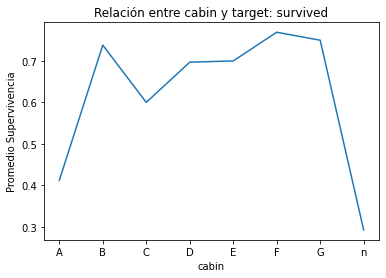

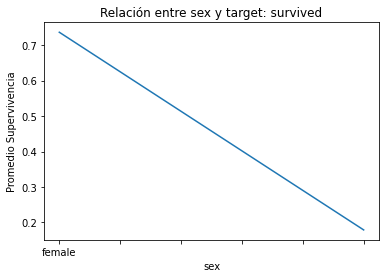

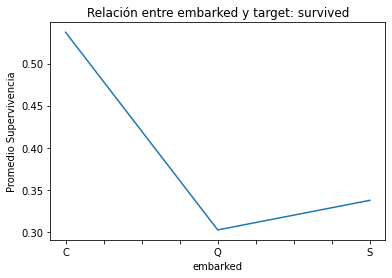

In [11]:
# Exploremos la relación original entre las variables categóricas 
# y el target survived

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación entre {} y target: survived'.format(var))
    fig.set_ylabel('Promedio Supervivencia')
    plt.show()

Podemos ver que la relación entre el target y las variables cabin/embarked sube y baja dependiendo de la categoría. 


## Pesos de Evidencia - Weight of Evidence con pandas

### Ventajas

- rápido
- retorna un pandas dataframe

### Limitaciones de pandas:

- no preserva la información del set de entrenamiento para propagarlo al segmento de prueba

Necesitamos capturar y guardar los mapeos uno por uno, manualmente, si estamos planeando usarlos en producción


In [12]:
# Calculamos la proporción de pasajeros que sobrevivieron 
# por categoría de la variable cabin con respecto al 
# total de sobrevivientes

# sobrevivientes totales
total_survived = X_train['survived'].sum()

# Porcentaje de pasajeros que sobrevivieron, del total de sobrevivientes
# por cada categoría de la variable cabin
survived = X_train.groupby(['cabin'])['survived'].sum() / total_survived
survived

cabin
A    0.020408
B    0.090379
C    0.122449
D    0.067055
E    0.061224
F    0.029155
G    0.008746
n    0.600583
Name: survived, dtype: float64

In [13]:
# Calculamos la proporción de pasajeros que no sobrevivieron 
# por categoría de la variable cabin con respecto al 
# total de pasajeros que no sobrevivientes

# total de pasajeros que no sobrevivieron
total_non_survived = len(X_train) - X_train['survived'].sum()

# Vamos a crear un marcador para los pasajeros que no sobrevivieron
X_train['non_survived'] = np.where(X_train['survived'] == 1, 0, 1)

# Ahora vamos a calcular el % de pasajeros que no sobrevivieron
# por categoría de la variable cabin
non_survived = X_train.groupby(
    ['cabin'])['non_survived'].sum() / total_non_survived

non_survived

cabin
A    0.017513
B    0.019264
C    0.049037
D    0.017513
E    0.015762
F    0.005254
G    0.001751
n    0.873905
Name: non_survived, dtype: float64

In [14]:
# Ahora combinemos esas dos series en un marco de datos y calculemos el
# WoE

# concatenemos la serie en un marco de datos
prob_df = pd.concat([survived, non_survived], axis=1)

# Vamos a calcular el peso de la evidencia
prob_df['woe'] = np.log(prob_df['survived']/prob_df['non_survived'])

prob_df

,survived,non_survived,woe
cabin,,,
A,0.020408,0.017513,0.152984
B,0.090379,0.019264,1.545751
C,0.122449,0.049037,0.915124
D,0.067055,0.017513,1.342568
E,0.061224,0.015762,1.356957
F,0.029155,0.005254,1.713632
G,0.008746,0.001751,1.608271
n,0.600583,0.873905,-0.375071


In [15]:
# y capturemos el WoE en un diccionario 

ordered_labels = prob_df['woe'].to_dict()

ordered_labels

{'A': 0.1529838185513379,
 'B': 1.545750694176846,
 'C': 0.9151238705982346,
 'D': 1.3425678854251744,
 'E': 1.356956622877274,
 'F': 1.7136315668160063,
 'G': 1.60827105115818,
 'n': -0.37507116447186734}

In [16]:
# ahora, reemplazamos cada etiqueta con el valor del WoE

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [17]:
# exporemos el resultado

X_train['cabin'].head(10)

843    -0.375071
869    -0.375071
430    -0.375071
481    -0.375071
1308   -0.375071
456    -0.375071
118     1.342568
485     1.342568
297    -0.375071
263     1.356957
Name: cabin, dtype: float64

In [18]:
# agrupemos los comandos anteriores en dos funciones

def find_category_mappings(df, variable, target):

    # copia del dataframe original, para que no lo modifiquemos
    # accidentalmente
    tmp = df.copy()

    # total classe positiva
    total_pos = df[target].sum()

    # total clase negativa
    total_neg = len(df) - df[target].sum()

    # inversa del target
    tmp['non-target'] = 1 - tmp[target]

    # % de clase positiva por categoría, respecto al total de clase positiva
    pos_perc = tmp.groupby([variable])[target].sum() / total_pos

    # % de clase negativa por categoría, respecto al total de la clase negativa
    neg_perc = tmp.groupby([variable])['non-target'].sum() / total_neg

    # concatenemos
    prob_tmp = pd.concat([pos_perc, neg_perc], axis=1)

    # calculemos el peso de la evidencia
    prob_tmp['woe'] = np.log(prob_tmp[target]/prob_tmp['non-target'])

    return prob_tmp['woe'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)

    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [19]:
# ahora repitamos el proceso para cada una de las variables categóricas

for variable in ['sex', 'embarked']:
    
    mappings = find_category_mappings(X_train, variable, 'survived')
    
    integer_encode(X_train, X_test, variable, mappings)

In [20]:
# veamos el resultado

X_train.head()

,cabin,sex,embarked,survived,non_survived
843,-0.375071,-1.013111,-0.164796,0,1
869,-0.375071,-1.013111,-0.164796,0,1
430,-0.375071,1.535068,-0.164796,1,0
481,-0.375071,1.535068,0.658871,1,0
1308,-0.375071,-1.013111,-0.164796,0,1


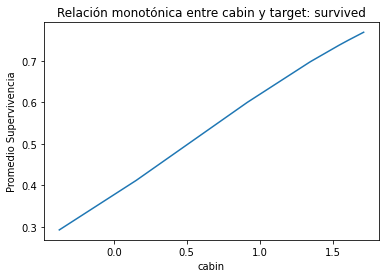

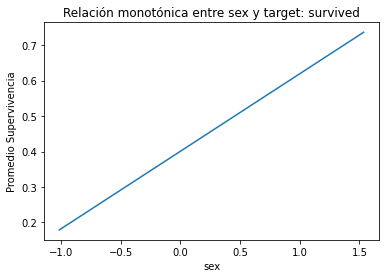

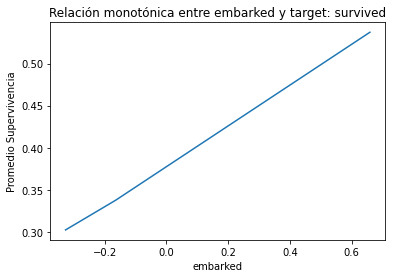

In [21]:
# inspeccionemos la relación monotónica
# entre la variable y el target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación monotónica entre {} y target: survived'.format(var))
    fig.set_ylabel('Promedio Supervivencia')
    plt.show()

Podemos ver de las gráficas que la relación entre las categorias y el target ahora es monotónica.

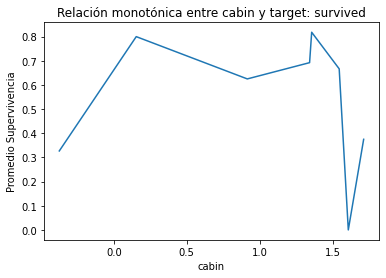

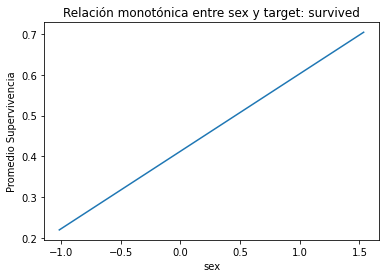

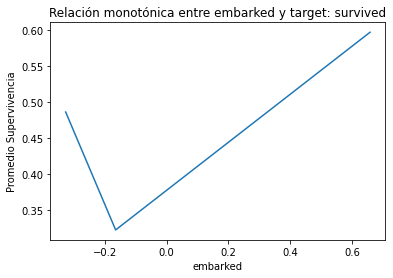

In [22]:
# ahora lo mismo en el test set

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_test.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación monotónica entre {} y target: survived'.format(var))
    fig.set_ylabel('Promedio Supervivencia')
    plt.show()

La relación monótonica no se mantiene cuando se codifican las variables categóricas del conjunto de pruebas. Esto podría significar que las categorías no son informativas o que la proporción de supervivientes no es homogénea entre las categorías del set de entrenamiento y prueba

En situaciones como ésta, podríamos intentar agrupar las etiquetas raras en una nueva categoría antes de aplicar la transformación del peso de la evidencia, como veremos más adelante en esta secció del curso. 

Traducción realizada con la versión gratuita del traductor www.DeepL.com/Translator

### Nota

Reemplazar las etiquetas con el código anterior, va a generar valores faltantes para las categorías presentes en el set de prueba pero que no lo están en el set de entrenamiento. 

Por lo tanto es extremadamente importante, manejar las etiquetas poco comunes con prelación. Explicaremos como hacer esto más adelante en otro notebook.

**Además, creará NA o Inf si cualquiera de los 2 términos en la proporción de la fórmula del peso de la evidencia son 0**

## Pesos de Evidencia - Weight of Evidence con feature-engine

Si usamos Feature-Engine, en lugar de pandas, no necesitamos mantener el target en el set de entrenamiento.

In [23]:
# separemos en set de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']], # predictores
    data['survived'],  # target
    test_size=0.3,  # porcentaje de observaciones en el set de prueba
    random_state=0)  # semilla asegurar reproducibilidad
X_train.shape, X_test.shape

((914, 3), (392, 3))

In [24]:
woe_enc = fe_WoEEncoder(
    variables=['cabin', 'sex', 'embarked'])

In [25]:
# cuando ajustamos el transformador, necesitamos pasar 
# el target, al igual que las otras clases de predictores de Scikit-learn 
woe_enc.fit(X_train, y_train)

WoEEncoder(variables=['cabin', 'sex', 'embarked'])

In [26]:
# en el atributo encoder_dict_ del codificador podemos ver el WoE
# asignado a cada una de las categoríaas por cada variable

woe_enc.encoder_dict_

{'cabin': {'A': 0.1529838185513379,
  'B': 1.545750694176846,
  'C': 0.9151238705982346,
  'D': 1.3425678854251744,
  'E': 1.356956622877274,
  'F': 1.7136315668160063,
  'G': 1.60827105115818,
  'n': -0.37507116447186734},
 'sex': {'female': 1.535067647134885, 'male': -1.0131107672983564},
 'embarked': {'C': 0.658871160676746,
  'Q': -0.3265892617105483,
  'S': -0.16479628505772237}}

In [27]:
# esta es la lista de variables que el codificador transforma
woe_enc.variables

['cabin', 'sex', 'embarked']

In [28]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# exploremos el resultado
X_train.head()

,cabin,sex,embarked
843,-0.375071,-1.013111,-0.164796
869,-0.375071,-1.013111,-0.164796
430,-0.375071,1.535068,-0.164796
481,-0.375071,1.535068,0.658871
1308,-0.375071,-1.013111,-0.164796


**Nota**

Si el argmento 'variables' se fija en 'None' (ninguno), entonces el codificador automáticamente indentificará  **todas las variables categóricas**. Maravilloso verdad?

El codificador no codificará las variables numéricas. Por lo tanto, si algunas de tus variables categóricas son de hecho numéricas, necesitas hacer el 're-cast' o cambio a tipo 'object' antes de usar el codificador.

Si hay una variable en el set de prueba, para el cual el codificador no tiene un número para asignar ( la categoría no estaba presente en el set de entrenamiento), el codificador devolverá un error para alertarte del problema.

Finalmente, si la probabilidad del target = 0 es cero para cualquier categoría, el codificador devolverá un error ya que la división por cero no esta definida.

## Peso de Evidencia - Weight of Evidence with Category Encoders

Si usamos Categoru encoders, en lugar de pandas, no necesitamos mantener el target en el set de entrenamiento.

In [29]:
# separemos en set de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']], # predictores
    data['survived'],  # target
    test_size=0.3,  # porcentaje de observaciones en el set de prueba
    random_state=0)  # semilla asegurar reproducibilidad
X_train.shape, X_test.shape

((914, 3), (392, 3))

In [30]:
woe_enc = WOEEncoder(cols=['cabin', 'sex', 'embarked'])

In [31]:
woe_enc.fit(X_train, y_train)

C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


WOEEncoder(cols=['cabin', 'sex', 'embarked'])

In [32]:
# los mapeos en los codificadores de categorías no son tan fáciles de interpretar
woe_enc.mapping

{'cabin': cabin
  1   -0.374548
  2    1.287500
  3    1.295799
  4    0.901246
  5    1.518942
  6    0.188888
  7    1.488171
  8    1.200488
 -1    0.000000
 -2    0.000000
 dtype: float64,
 'sex': sex
  1   -1.008094
  2    1.525265
 -1    0.000000
 -2    0.000000
 dtype: float64,
 'embarked': embarked
  1   -0.164851
  2    0.654977
  3   -0.307696
 -1    0.000000
 -2    0.000000
 dtype: float64}

In [33]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# exploremos el resultado
X_train.head()

,cabin,sex,embarked
843,-0.374548,-1.008094,-0.164851
869,-0.374548,-1.008094,-0.164851
430,-0.374548,1.525265,-0.164851
481,-0.374548,1.525265,0.654977
1308,-0.374548,-1.008094,-0.164851
